In [1]:
import torch
import pickle
from main_mlp import *
import torch.nn as nn
from matplotlib import pyplot as plt
plt.style.use("bmh")


def get_list(model_name, ext):
    target_list = []
    filename = f"/shared/vsathia2/inference_outputs/{model_name}_{ext}"
    with open(filename, "rb") as fp:
        target_list = pickle.load(fp)
    return target_list

def generate_label(y, thresh=0):
    # positive
    one_hot = (y > thresh).to(y.dtype)
    return one_hot


In [14]:
def visualize_all(values, model_names, title = "", filename = "sparsity.png", ylabel = 'Sparsity (%)', xlabel = 'Transformer layer'):
    for i, model_name in enumerate(model_names):
        n_layers = len(values[i])
        plt.plot(np.arange(n_layers), values[i], label =  model_name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.savefig(filename)

In [15]:
def evaluate_sparsity(model_name, all_outputs):
    layer_sparsity = [0]*50

    n_layers = len(all_outputs)
    for i in range(n_layers):
        curr_out = all_outputs[i]
        y = generate_label(curr_out)
        # sparsity = y.sum()
        
        layer_sparsity[i] += (1.0 - (torch.count_nonzero(curr_out)/torch.numel(curr_out)))*100.0
        #layer_sparsity[i] += y.sum(dim=-1).float().mean().item()
        print(f"layer_sparsity : {(layer_sparsity[i].item())}%")
    
    layer_sparsity = torch.tensor(layer_sparsity, device = 'cpu')
    return layer_sparsity[:n_layers]
    

layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_sparsity : 71.39714050292969%
layer_sparsity : 70.43721771240234%
layer_sparsity : 68.07931518554688%
layer_sparsity : 68.81309509277344%
layer_sparsity : 67.7017822265625%
layer_sparsity : 67.40618133544922%
layer_sparsity : 67.91454315185547%
layer_sparsity : 67.3946533203125%
layer_sparsity : 69.37055969238281%
layer_sparsity : 70.23057556152344%
layer_sparsity : 69.78174591064453%
layer_sparsity : 67.42063903808594%
layer_sparsity : 67.79874420166016%
layer_sparsity : 66.80530548095703%
layer_sparsity : 66.02950286865234%
layer_sparsity : 64.96153259277344%
layer_sparsity : 64.33921813964844%
layer_sparsity : 64.25597381591797%
layer_sparsity : 64.29228973388672%
layer_sparsity : 64.767593383789

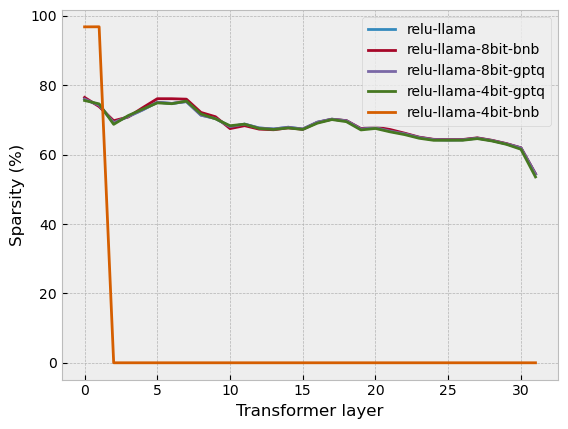

In [10]:
model_names = ["relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "relu llamasparsity with 4bnb.png")

layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_spar

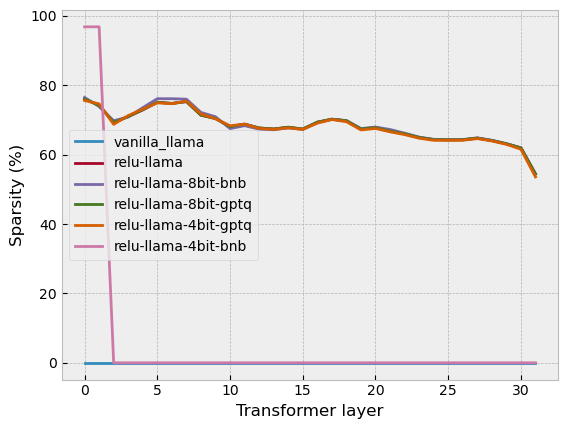

In [12]:
model_names = ["vanilla_llama", "relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq", "relu-llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "vanila_and_relu llamasparsity with 4bnb.png")

layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_sparsity : 71.39714050292969%
layer_sparsity : 70.43721771240234%
layer_sparsity : 68.07931518554688%
layer_sparsity : 68.81309509277344%
layer_sparsity : 67.7017822265625%
layer_sparsity : 67.40618133544922%
layer_sparsity : 67.91454315185547%
layer_sparsity : 67.3946533203125%
layer_sparsity : 69.37055969238281%
layer_sparsity : 70.23057556152344%
layer_sparsity : 69.78174591064453%
layer_sparsity : 67.42063903808594%
layer_sparsity : 67.79874420166016%
layer_sparsity : 66.80530548095703%
layer_sparsity : 66.02950286865234%
layer_sparsity : 64.96153259277344%
layer_sparsity : 64.33921813964844%
layer_sparsity : 64.25597381591797%
layer_sparsity : 64.29228973388672%
layer_sparsity : 64.767593383789

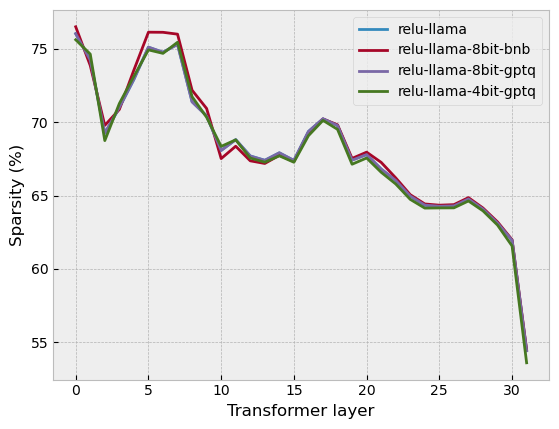

In [7]:
model_names = ["relu-llama", "relu-llama-8bit-bnb", "relu-llama-8bit-gptq", "relu-llama-4bit-gptq"]#, "relu-llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "sparsity wo 4bnb.png")

layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0025391578674316406%
layer_sparsity : 0.0012218952178955078%
layer_sparsity : 0.0006020069122314453%
layer_sparsity : 0.0008225440979003906%
layer_sparsity : 0.00019669532775878906%
layer_sparsity : 0.0008165836334228516%
layer_sparsity : 0.0008881092071533203%
layer_sparsity 

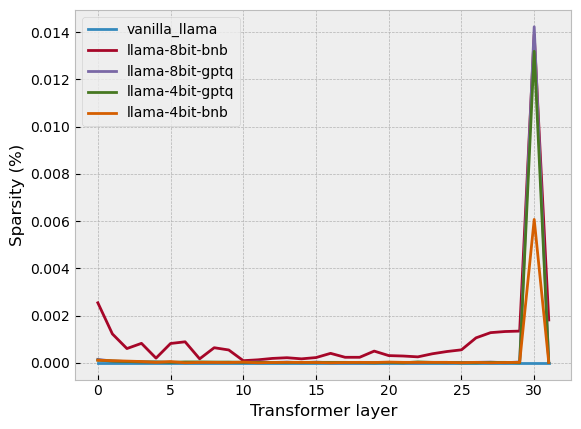

In [9]:
model_names = ["vanilla_llama", "llama-8bit-bnb", "llama-8bit-gptq",  "llama-4bit-gptq", "llama-4bit-bnb"] 

D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "vanilla_llama_variations.png")

layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 0.0%
layer_sparsity : 76.03953552246094%
layer_sparsity : 74.24092102050781%
layer_sparsity : 69.2383041381836%
layer_sparsity : 70.98551940917969%
layer_sparsity : 72.9100341796875%
layer_sparsity : 75.11522674560547%
layer_sparsity : 74.77230072021484%
layer_sparsity : 75.31289672851562%
layer_spar

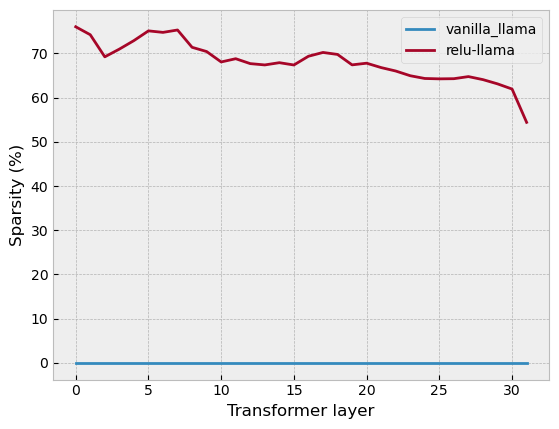

In [16]:
model_names = ["vanilla_llama", "relu-llama"]


D = 1000
sparsity_list = [[]]*len(model_names)
#act_outputs_list = [[]]*len(model_names)

for i, model_name in enumerate(model_names):
    act_outputs = get_list(model_name, "act_outputs")
    model_sparsity = evaluate_sparsity(model_name, act_outputs)

    sparsity_list[i] = model_sparsity
visualize_all(sparsity_list, model_names, filename = "vanilla_vs_relu.png")

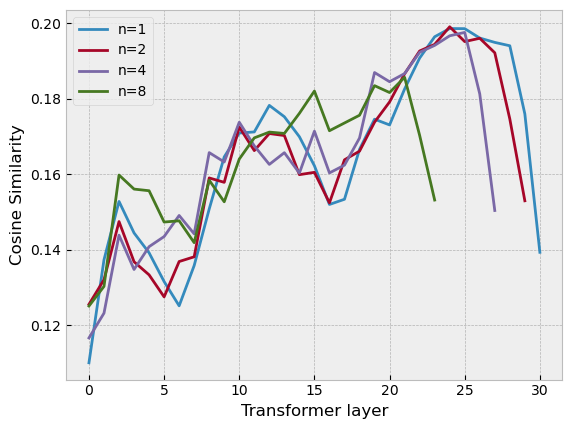

In [8]:
import torch.nn.functional as F
import pandas as pd
model_name = "relu-llama"
all_outputs = get_list(model_name, "act_outputs")
n_layers = len(all_outputs)
d = {"1":np.zeros(n_layers),"2":np.zeros(n_layers),"4":np.zeros(n_layers),"8":np.zeros(n_layers)}
df = pd.DataFrame(data=d)

for nsep in [1,2,4,8]:
    #Compute cosine similarity
    for i in range(n_layers):
        vec1 = all_outputs[i]
        if (i+nsep) < n_layers:
            vec2 = all_outputs[i+nsep]
        else:
            vec2 = all_outputs[i-nsep]
        out=F.cosine_similarity(vec1,vec2,dim=-1)
        
        out=out.mean().item()
        df.at[i,str(nsep)] = out
        # import torch.nn as nn
plt.plot(np.arange(n_layers-1), df['1'][:n_layers-1], label =  'n=1')
plt.plot(np.arange(n_layers-2), df['2'][:n_layers-2], label =  'n=2')
plt.plot(np.arange(n_layers-4), df['4'][:n_layers-4], label =  'n=4')
plt.plot(np.arange(n_layers-8), df['8'][:n_layers-8], label =  'n=8')
plt.xlabel('Transformer layer')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.savefig("nsep.png")